# Projeto Final: Previsão de Demanda Energética e Análise Setorial

**Objetivo:** Construir um pipeline completo de Data Science para prever a demanda diária de energia em Pernambuco, identificar os principais fatores de consumo e analisar o cenário do setor elétrico brasileiro.

**Fases do Projeto:**
1.  **Configuração:** Instalação das bibliotecas.
2.  **ETL (Extract, Transform, Load):** Coleta e limpeza dos 3 datasets (Consumo, Clima, População).
3.  **Engenharia de Features:** Criação do DataFrame Master com dados de calendário.
4.  **Machine Learning (XGBoost):** Treinamento do modelo principal (para PE) e avaliação de métricas (MAPE).
5.  **Dashboard (Visualização):** Geração do gráfico de previsão e do mapa de consumo.
6.  **Relatório Técnico:** Análise dos fatores de risco e insights do modelo.
7.  **Machine Learning (Prophet):** Treinamento do modelo secundário para comparação.
8.  **PLN (Processamento de Linguagem Natural):** Análise de notícias do setor.

In [1]:
# 1. Instalação das bibliotecas de ML, Dashboard e Geo
!pip install pandas xgboost scikit-learn holidays geopandas geobr

# 2. Instalação do Prophet (separadamente para evitar conflitos)
!pip install --upgrade prophet cmdstanpy

# 3. Instalação do spaCy (para PLN)
!pip install spacy
!python -m spacy download pt_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 1.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Importar bibliotecas principais
import pandas as pd
import numpy as np
import os
import glob
import warnings
from google.colab import drive

# Imports de Machine Learning
import xgboost as xgb
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import holidays

# Imports de Visualização (Dashboard)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas
import geobr

# Imports de PLN
import spacy

# Configurações
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:,.2f}'.format

# Conectar ao Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Fase 2: ETL (Coleta e Limpeza de Dados)

Nesta fase, carregamos os 3 arquivos CSV brutos e os limpamos.

In [3]:
# Caminho para o arquivo de consumo
arquivo_consumo = '/content/drive/My Drive/Projeto_Energia/Consumo_historico_por_regiao.csv'
print(f"Carregando {arquivo_consumo}...")

try:
    df_consumo = pd.read_csv(
        arquivo_consumo,
        sep='\t',
        decimal=',',
        thousands='.',
        encoding='utf-16'
    )
    # Limpeza e formatação
    df_consumo = df_consumo.rename(columns={'Data': 'data', 'Submercado': 'submercado', 'Estado': 'estado', 'Consumo (MWm)': 'consumo_mwm'})
    df_consumo['data'] = pd.to_datetime(df_consumo['data'], format='%d/%m/%Y')
    df_consumo = df_consumo[['data', 'submercado', 'estado', 'consumo_mwm']]
    df_consumo['estado'] = df_consumo['estado'].str.strip()

    print("\n--- Bloco A (Consumo) Concluído ---")
    df_consumo.info()
except Exception as e:
    print(f"ERRO no Bloco A: {e}")

Carregando /content/drive/My Drive/Projeto_Energia/Consumo_historico_por_regiao.csv...

--- Bloco A (Consumo) Concluído ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9663 entries, 0 to 9662
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         9663 non-null   datetime64[ns]
 1   submercado   9663 non-null   object        
 2   estado       9663 non-null   object        
 3   consumo_mwm  9663 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 302.1+ KB


In [4]:
# Caminho para a pasta com TODOS os arquivos .CSV do INMET
pasta_clima = '/content/drive/My Drive/Projeto_Energia/CLIMA_DIARIO/'

# Mapas de conversão
mapa_sigla_estado = {
    'PE': 'Pernambuco', 'BA': 'Bahia', 'CE': 'Ceará', 'AL': 'Alagoas', 'PB': 'Paraíba',
    'RN': 'Rio Grande do Norte', 'PI': 'Piauí', 'SE': 'Sergipe', 'MA': 'Maranhão',
    'SP': 'São Paulo', 'RJ': 'Rio de Janeiro', 'MG': 'Minas Gerais', 'ES': 'Espírito Santo',
    'RS': 'Rio Grande do Sul', 'SC': 'Santa Catarina', 'PR': 'Paraná', 'GO': 'Goiás',
    'MT': 'Mato Grosso', 'MS': 'Mato Grosso do Sul', 'DF': 'Distrito Federal',
    'AM': 'Amazonas', 'PA': 'Pará', 'TO': 'Tocantins', 'AC': 'Acre', 'RO': 'Rondônia',
    'AP': 'Amapá', 'RR': 'Roraima'
}
mapa_estacao_principal = {
    'AC': 'A101', 'AL': 'A303', 'AP': 'A109', 'AM': 'A102', 'BA': 'A401', 'CE': 'A305',
    'DF': 'A001', 'ES': 'A602', 'GO': 'A002', 'MA': 'A302', 'MT': 'A901', 'MS': 'A702',
    'MG': 'A501', 'PA': 'A201', 'PB': 'A304', 'PR': 'A807', 'PE': 'A301', 'PI': 'A306',
    'RJ': 'A601', 'RN': 'A307', 'RS': 'A801', 'RO': 'A902', 'RR': 'A103', 'SC': 'A802',
    'SP': 'A701', 'SE': 'A308', 'TO': 'A003'
}
estacoes_principais = set(mapa_estacao_principal.values())

lista_clima = []
arquivos_csv = glob.glob(os.path.join(pasta_clima, '*.csv')) + glob.glob(os.path.join(pasta_clima, '*.CSV'))
print(f"Encontrados {len(arquivos_csv)} arquivos de clima. Processando estações principais...")

for arquivo in arquivos_csv:
    try:
        nome_base = os.path.basename(arquivo)
        sigla_estado = nome_base.split('_')[2]
        cod_estacao = nome_base.split('_')[3]

        if sigla_estado in mapa_sigla_estado and cod_estacao in estacoes_principais:
            nome_estado = mapa_sigla_estado[sigla_estado]
            df_clima_horario = pd.read_csv(
                arquivo, sep=';', skiprows=8, encoding='latin-1', decimal=','
            )

            # Mapear colunas horárias
            colunas_clima_mapa = {
                'Data': 'data',
                'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp_horaria',
                'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade_horaria',
                'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'chuva_horaria'
            }
            colunas_reais = {k: v for k, v in colunas_clima_mapa.items() if k in df_clima_horario.columns}
            df_clima_horario = df_clima_horario[colunas_reais.keys()]
            df_clima_horario = df_clima_horario.rename(columns=colunas_reais)

            # Limpeza e agregação
            df_clima_horario['data'] = pd.to_datetime(df_clima_horario['data'])
            df_clima_horario = df_clima_horario.replace([-9999, -999.9], np.nan).ffill()

            df_clima_diario_estacao = df_clima_horario.groupby('data').agg(
                temp_media=('temp_horaria', 'mean'),
                umidade_media=('umidade_horaria', 'mean'),
                chuva_mm=('chuva_horaria', 'sum')
            ).reset_index()

            df_clima_diario_estacao['estado'] = nome_estado
            lista_clima.append(df_clima_diario_estacao)
    except Exception as e:
        print(f"FALHA ao processar {arquivo}. Erro: {e}")

df_clima_diario = pd.concat(lista_clima, ignore_index=True).ffill()
print("\n--- Bloco B (Clima) Concluído ---")
df_clima_diario.info()

Encontrados 565 arquivos de clima. Processando estações principais...

--- Bloco B (Clima) Concluído ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8418 entries, 0 to 8417
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   data           8418 non-null   datetime64[ns]
 1   temp_media     8418 non-null   float64       
 2   umidade_media  8418 non-null   float64       
 3   chuva_mm       8418 non-null   float64       
 4   estado         8418 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 329.0+ KB


In [5]:
# Caminho para o arquivo de população
arquivo_populacao = '/content/drive/My Drive/Projeto_Energia/crescimento_populacional_regioes_2020_2024.csv'
print(f"\nCarregando {arquivo_populacao}...")

try:
    df_populacao = pd.read_csv(arquivo_populacao)
    df_populacao = df_populacao.rename(columns={'Região': 'regiao', 'População 2024': 'populacao_regiao'})
    df_populacao = df_populacao[['regiao', 'populacao_regiao']]
    df_populacao = df_populacao[df_populacao['regiao'] != 'Brasil']

    print("\n--- Bloco C (População) Concluído ---")
    df_populacao.info()
except Exception as e:
    print(f"ERRO no Bloco C: {e}")


Carregando /content/drive/My Drive/Projeto_Energia/crescimento_populacional_regioes_2020_2024.csv...

--- Bloco C (População) Concluído ---
<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   regiao            5 non-null      object
 1   populacao_regiao  5 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 120.0+ bytes


## Fase 3: Engenharia de Features e DataFrame Master

Agora, juntamos os três DataFrames em um único `df_final`. Esta é a etapa mais crítica.

1.  **Junção (Merge):** Unimos `df_consumo` e `df_clima_diario` usando `data` e `estado`.
2.  **Correção de Duplicatas:** Agregamos (com `mean`) o clima de estados que tinham múltiplas estações.
3.  **Limpeza (DropNA):** Removemos os dias/estados para os quais **não** tínhamos dados climáticos, garantindo um dataset de alta qualidade.
4.  **Enriquecimento:** Adicionamos os dados de `populacao_regiao` e as features de calendário (feriados, etc.).

In [6]:
print("--- Iniciando Fase 3: Junção e Features ---")

# 1. Corrigir duplicatas do df_clima (agrupar múltiplas estações por estado)
df_clima_diario_corrigido = df_clima_diario.groupby(['data', 'estado']).agg(
    temp_media=('temp_media', 'mean'),
    umidade_media=('umidade_media', 'mean'),
    chuva_mm=('chuva_mm', 'mean')
).reset_index()

# 2. Juntar Consumo + Clima
df_final = pd.merge(
    df_consumo,
    df_clima_diario_corrigido,
    on=['data', 'estado'],
    how='left' # 'left' é crucial
)

# 3. Limpeza de Nulos (REMOVER dados sem clima)
print(f"Total de linhas (antes de limpar): {len(df_final)}")
linhas_faltantes = df_final['temp_media'].isnull().sum()
print(f"Linhas com dados de clima faltantes: {linhas_faltantes}")
df_final = df_final.dropna(subset=['temp_media']) # A etapa de limpeza mais importante
print(f"Total de linhas (DEPOIS de limpar): {len(df_final)}")

# 4. Juntar População
mapa_estado_regiao = {
    'Alagoas': 'Nordeste', 'Bahia': 'Nordeste', 'Ceará': 'Nordeste', 'Maranhão': 'Nordeste',
    'Paraíba': 'Nordeste', 'Pernambuco': 'Nordeste', 'Piauí': 'Nordeste',
    'Rio Grande do Norte': 'Nordeste', 'Sergipe': 'Nordeste', 'Acre': 'Norte',
    'Amapá': 'Norte', 'Amazonas': 'Norte', 'Pará': 'Norte', 'Rondônia': 'Norte',
    'Roraima': 'Norte', 'Tocantins': 'Norte', 'Espírito Santo': 'Sudeste',
    'Minas Gerais': 'Sudeste', 'Rio de Janeiro': 'Sudeste', 'São Paulo': 'Sudeste',
    'Paraná': 'Sul', 'Rio Grande do Sul': 'Sul', 'Santa Catarina': 'Sul',
    'Distrito Federal': 'Centro-Oeste', 'Goiás': 'Centro-Oeste',
    'Mato Grosso': 'Centro-Oeste', 'Mato Grosso do Sul': 'Centro-Oeste'
}
df_final['regiao'] = df_final['estado'].map(mapa_estado_regiao)
df_final = pd.merge(df_final, df_populacao, on='regiao', how='left')

# 5. Criar Features de Calendário
df_final['dia_da_semana'] = df_final['data'].dt.dayofweek
df_final['dia_do_mes'] = df_final['data'].dt.day
df_final['mes_num'] = df_final['data'].dt.month
df_final['dia_do_ano'] = df_final['data'].dt.dayofyear
df_final['semana_do_ano'] = df_final['data'].dt.isocalendar().week
df_final['eh_fim_de_semana'] = df_final['dia_da_semana'].isin([5, 6]).astype(int)
feriados_br_2024 = holidays.Brazil(years=2024)
df_final['eh_feriado'] = df_final['data'].isin(feriados_br_2024).astype(int)

print("\n--- DataFrame Master 'df_final' Concluído ---")
df_final.info()

--- Iniciando Fase 3: Junção e Features ---
Total de linhas (antes de limpar): 9663
Linhas com dados de clima faltantes: 3292
Total de linhas (DEPOIS de limpar): 6371

--- DataFrame Master 'df_final' Concluído ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6371 entries, 0 to 6370
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   data              6371 non-null   datetime64[ns]
 1   submercado        6371 non-null   object        
 2   estado            6371 non-null   object        
 3   consumo_mwm       6371 non-null   float64       
 4   temp_media        6371 non-null   float64       
 5   umidade_media     6371 non-null   float64       
 6   chuva_mm          6371 non-null   float64       
 7   regiao            6371 non-null   object        
 8   populacao_regiao  6371 non-null   int64         
 9   dia_da_semana     6371 non-null   int32         
 10  dia_do_mes        6371 non

## Fase 4: Machine Learning (Modelo 1: XGBoost)

Com os dados prontos, filtramos para nosso alvo (Pernambuco) e treinamos o modelo XGBoost.

In [7]:
print("--- Fase 4: Preparando dados para Pernambuco ---")

# 1. Filtrar o DataFrame apenas para Pernambuco
df_pe = df_final[df_final['estado'] == 'Pernambuco'].copy()
df_pe = df_pe.set_index('data')
print(f"Total de dias com dados para PE: {len(df_pe)}")

# 2. Definir Alvo (y) e Features (X)
y_pe = df_pe['consumo_mwm']
X_pe = df_pe.drop(columns=[
    'consumo_mwm', 'submercado', 'estado', 'regiao', 'populacao_regiao'
])
print(f"Features (X_pe) definidas: {X_pe.columns.to_list()}")

# 3. Dividir em Treino (Jan-Out) e Teste (Nov-Dez)
data_corte = '2024-11-01'
X_treino_pe = X_pe[X_pe.index < data_corte]
y_treino_pe = y_pe[y_pe.index < data_corte]
X_teste_pe = X_pe[X_pe.index >= data_corte]
y_teste_pe = y_pe[y_pe.index >= data_corte]

print(f"Linhas de Treino: {len(X_treino_pe)}, Linhas de Teste: {len(X_teste_pe)}")

--- Fase 4: Preparando dados para Pernambuco ---
Total de dias com dados para PE: 359
Features (X_pe) definidas: ['temp_media', 'umidade_media', 'chuva_mm', 'dia_da_semana', 'dia_do_mes', 'mes_num', 'dia_do_ano', 'semana_do_ano', 'eh_fim_de_semana', 'eh_feriado']
Linhas de Treino: 298, Linhas de Teste: 61


In [8]:
print("--- Fase 4: Treinamento e Métricas (XGBoost) ---")

# 1. Definir e Treinar o modelo
modelo_xgb_pe = xgb.XGBRegressor(
    n_estimators=1000, learning_rate=0.05, early_stopping_rounds=50, random_state=42
)
print("Treinando o modelo XGBoost...")
modelo_xgb_pe.fit(
    X_treino_pe, y_treino_pe, eval_set=[(X_teste_pe, y_teste_pe)], verbose=False
)
print("--- Modelo XGBoost treinado com sucesso! ---")

# 2. Fazer previsões
previsoes_pe = modelo_xgb_pe.predict(X_teste_pe)

# 3. Calcular Métricas
mae_xgb = mean_absolute_error(y_teste_pe, previsoes_pe)
mape_xgb = mean_absolute_percentage_error(y_teste_pe, previsoes_pe)

# Função SMAPE (Simétrica)
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 100 * np.mean(diff)

smape_xgb = smape(y_teste_pe, previsoes_pe)

print("\n--- Métricas de Performance (XGBoost) ---")
print(f"MAE (Erro Médio): {mae_xgb:.2f} MWm")
print(f"MAPE (Erro Percentual): {mape_xgb * 100:.2f} %")
print(f"SMAPE (Erro Simétrico): {smape_xgb:.2f} %")

--- Fase 4: Treinamento e Métricas (XGBoost) ---
Treinando o modelo XGBoost...
--- Modelo XGBoost treinado com sucesso! ---

--- Métricas de Performance (XGBoost) ---
MAE (Erro Médio): 75.91 MWm
MAPE (Erro Percentual): 4.85 %
SMAPE (Erro Simétrico): 4.99 %


## Fase 5: Dashboard e Visualização

Com o modelo treinado, geramos os principais componentes visuais do dashboard.

--- Fase 5: Gráfico de Previsão (Real vs. Previsto) ---


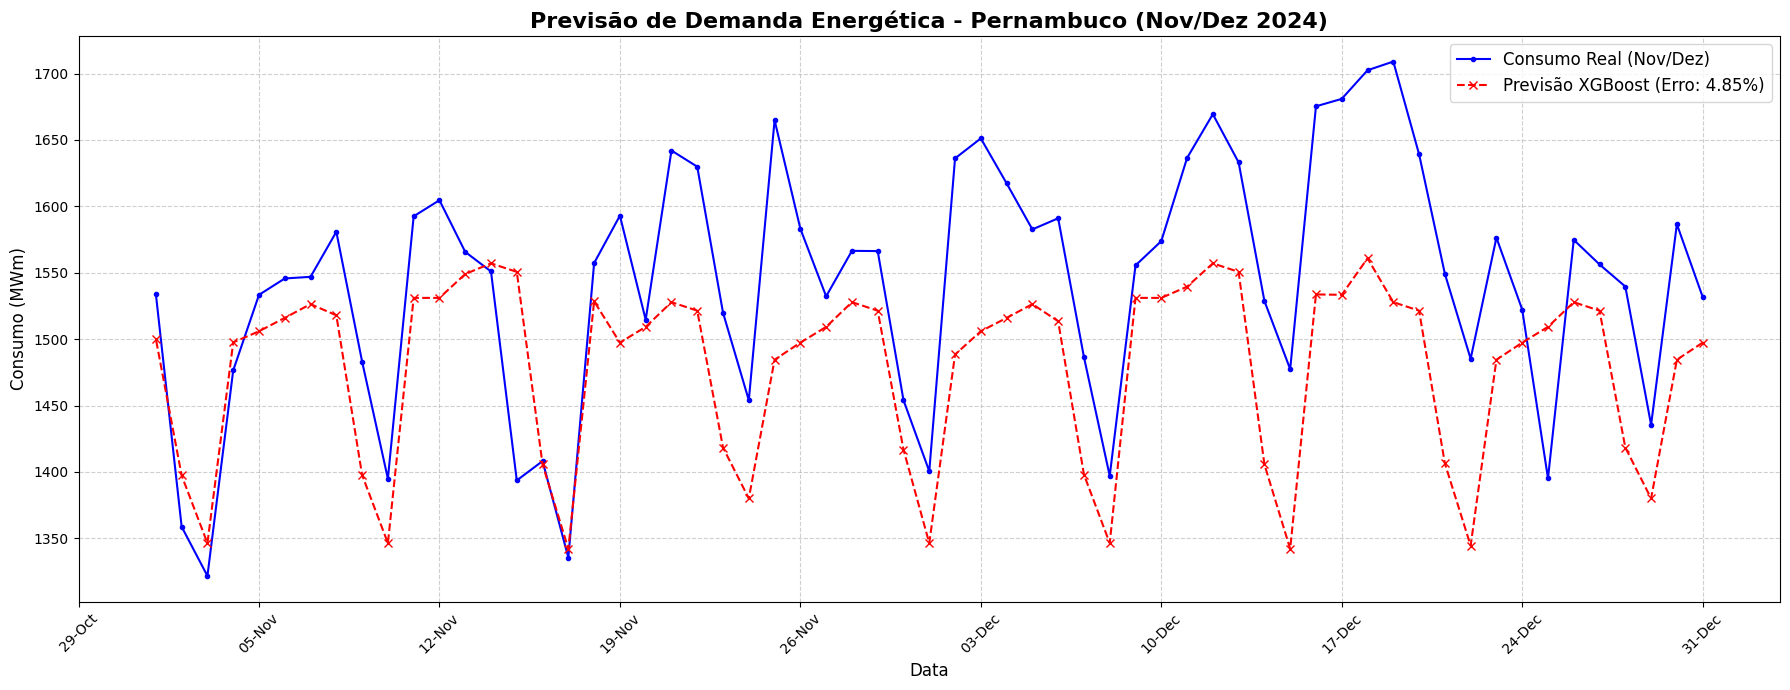

In [9]:
print("--- Fase 5: Gráfico de Previsão (Real vs. Previsto) ---")

df_resultados_pe = pd.DataFrame({'Consumo Real': y_teste_pe, 'Consumo Previsto': previsoes_pe})

plt.figure(figsize=(18, 7))
plt.plot(df_resultados_pe.index, df_resultados_pe['Consumo Real'], label='Consumo Real (Nov/Dez)', color='blue', marker='.')
plt.plot(df_resultados_pe.index, df_resultados_pe['Consumo Previsto'], label=f'Previsão XGBoost (Erro: {mape_xgb*100:.2f}%)', color='red', linestyle='--', marker='x')
plt.title('Previsão de Demanda Energética - Pernambuco (Nov/Dez 2024)', fontsize=16, fontweight='bold')
plt.ylabel('Consumo (MWm)', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

--- Fase 5: Mapa de Consumo por Estado ---
Baixando o mapa oficial dos estados do Brasil (via geobr)...
Mapa carregado.
Plotando o Mapa...


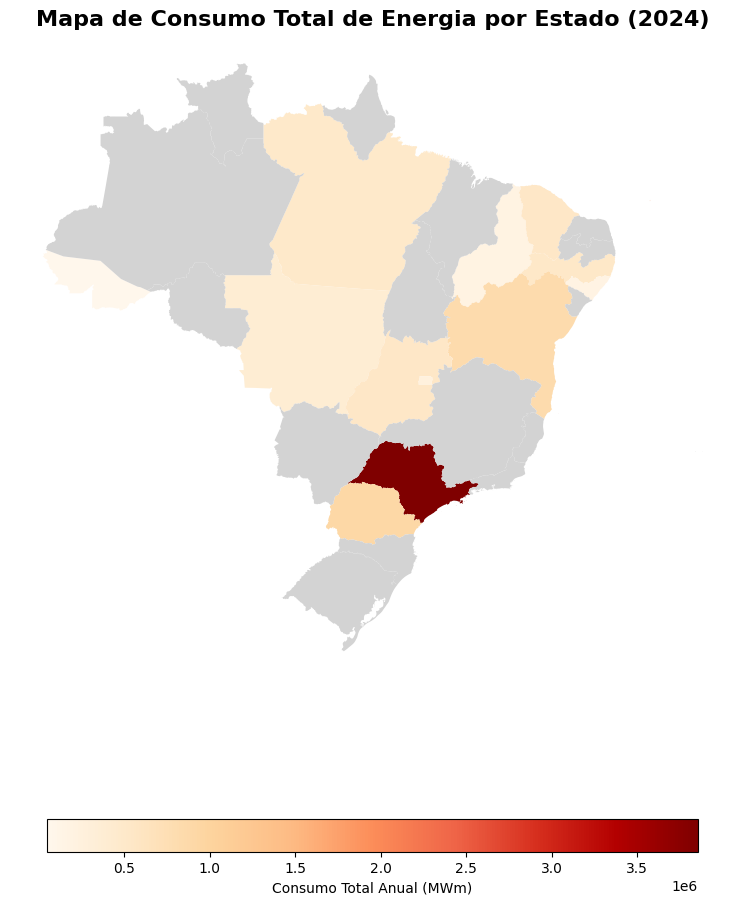

In [10]:
print("--- Fase 5: Mapa de Consumo por Estado ---")

try:
    print("Baixando o mapa oficial dos estados do Brasil (via geobr)...")
    mapa_brasil_estados = geobr.read_state(year=2020)
    print("Mapa carregado.")

    # Preparar dados para o mapa (usando o df_final completo)
    df_consumo_mapa = df_final.groupby('estado')['consumo_mwm'].sum().reset_index()
    df_consumo_mapa = df_consumo_mapa.rename(columns={'consumo_mwm': 'consumo_total_ano'})
    mapa_brasil_estados = mapa_brasil_estados.rename(columns={'name_state': 'estado'})

    # Juntar dados ao mapa
    mapa_com_dados = mapa_brasil_estados.merge(df_consumo_mapa, on='estado', how='left')

    # Plotar
    print("Plotando o Mapa...")
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    mapa_com_dados.plot(
        column='consumo_total_ano', ax=ax, legend=True, cmap='OrRd',
        missing_kwds={"color": "lightgrey", "label": "Dados Indisponíveis"},
        legend_kwds={'label': "Consumo Total Anual (MWm)", 'orientation': "horizontal", 'shrink': 0.7}
    )
    ax.set_title('Mapa de Consumo Total de Energia por Estado (2024)', fontsize=16, fontweight='bold')
    ax.set_axis_off()
    plt.show()

except Exception as e:
    print(f"ERRO ao gerar o mapa: {e}")

## Fase 6: Relatório Técnico e Insights

Geramos o relatório final, analisando os fatores de risco (Feature Importance) do nosso modelo vencedor (XGBoost).

--- Fase 6: Relatório Técnico e Análise de Insights ---

--- Fatores de Risco (Feature Importance) para Pernambuco ---
            Feature  Importância
6        dia_do_ano         0.51
9        eh_feriado         0.22
3     dia_da_semana         0.16
2          chuva_mm         0.05
0        temp_media         0.02
5           mes_num         0.02
1     umidade_media         0.02
4        dia_do_mes         0.01
7     semana_do_ano         0.00
8  eh_fim_de_semana         0.00


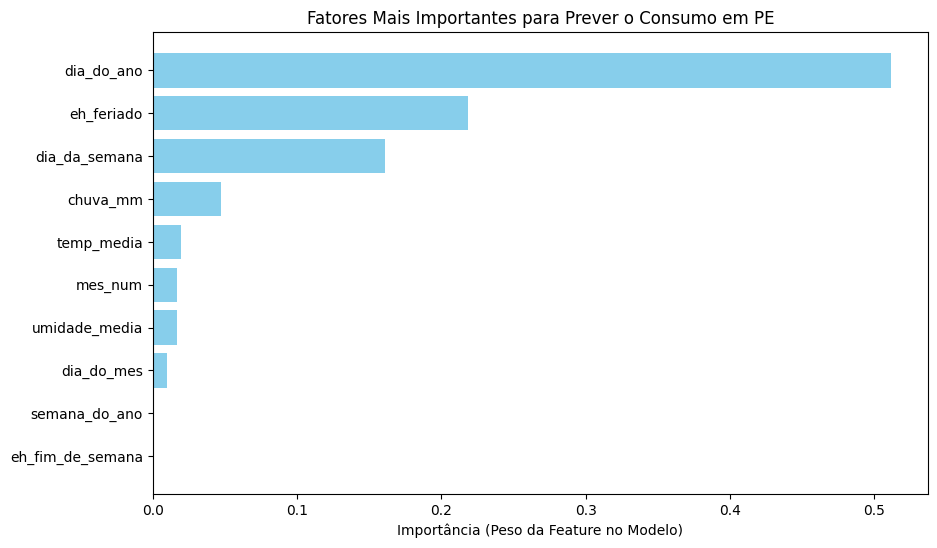



 RELATÓRIO TÉCNICO: OTIMIZADOR DE CONSUMO ENERGÉTICO (PERNAMBUCO)

◆ Resumo Executivo
- Previsão de consumo para Nov/Dez 2024 realizada com sucesso (MAPE: 4.85%).
- Média de consumo prevista: 1478.80 MWm (vs. Média Real de 1542.64 MWm).
- Alerta de Pico: Risco de maior demanda identificado para o dia 18/12/2024 (1560.89 MWm).
- Recomendação: Monitorar dia_do_ano, principal fator de risco identificado.

◆ Metodologia
- Dados: 6371 registros diários de consumo (CCEE) e clima (INMET) para 2024.
- Algoritmo: XGBoost (eXtreme Gradient Boosting) focado no estado de Pernambuco.
- Validação: Modelo treinado com dados de Jan-Out (298 dias) e testado em Nov-Dez (61 dias).

◆ Fatores de Risco Identificados (Feature Importance)
1. dia_do_ano (peso: 0.51)
2. eh_feriado (peso: 0.22)
3. dia_da_semana (peso: 0.16)

◆ Confiabilidade do Modelo (XGBoost)
- Acurácia (1 - MAPE): 95.15%
- Erro Percentual Médio (MAPE): 4.85%
- Erro Absoluto Médio (MAE): 75.91 MWm


In [11]:
print("--- Fase 6: Relatório Técnico e Análise de Insights ---")

# --- 1. Análise de Fatores (Feature Importance) ---
print("\n--- Fatores de Risco (Feature Importance) para Pernambuco ---")
feature_importance = pd.DataFrame({
    'Feature': X_treino_pe.columns,
    'Importância': modelo_xgb_pe.feature_importances_
}).sort_values(by='Importância', ascending=False)
print(feature_importance)

# Plotar gráfico de importância
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importância'], color='skyblue')
plt.xlabel("Importância (Peso da Feature no Modelo)")
plt.title("Fatores Mais Importantes para Prever o Consumo em PE")
plt.gca().invert_yaxis()
plt.show()

# --- 2. Geração do Relatório Técnico (Texto) ---
media_real_nov_dez = y_teste_pe.mean()
media_prevista_nov_dez = previsoes_pe.mean()
data_maior_pico = df_resultados_pe['Consumo Previsto'].idxmax().strftime('%d/%m/%Y')
valor_maior_pico = df_resultados_pe['Consumo Previsto'].max()
feature_principal = feature_importance.iloc[0]['Feature']

print("\n\n" + "="*70)
print(" RELATÓRIO TÉCNICO: OTIMIZADOR DE CONSUMO ENERGÉTICO (PERNAMBUCO)")
print("="*70)
print("\n◆ Resumo Executivo")
print(f"- Previsão de consumo para Nov/Dez 2024 realizada com sucesso (MAPE: {mape_xgb * 100:.2f}%).")
print(f"- Média de consumo prevista: {media_prevista_nov_dez:.2f} MWm (vs. Média Real de {media_real_nov_dez:.2f} MWm).")
print(f"- Alerta de Pico: Risco de maior demanda identificado para o dia {data_maior_pico} ({valor_maior_pico:.2f} MWm).")
print(f"- Recomendação: Monitorar {feature_principal}, principal fator de risco identificado.")
print("\n◆ Metodologia")
print(f"- Dados: {len(df_final)} registros diários de consumo (CCEE) e clima (INMET) para 2024.")
print(f"- Algoritmo: XGBoost (eXtreme Gradient Boosting) focado no estado de Pernambuco.")
print(f"- Validação: Modelo treinado com dados de Jan-Out ({len(X_treino_pe)} dias) e testado em Nov-Dez ({len(X_teste_pe)} dias).")
print("\n◆ Fatores de Risco Identificados (Feature Importance)")
print(f"1. {feature_importance.iloc[0]['Feature']} (peso: {feature_importance.iloc[0]['Importância']:.2f})")
print(f"2. {feature_importance.iloc[1]['Feature']} (peso: {feature_importance.iloc[1]['Importância']:.2f})")
print(f"3. {feature_importance.iloc[2]['Feature']} (peso: {feature_importance.iloc[2]['Importância']:.2f})")
print("\n◆ Confiabilidade do Modelo (XGBoost)")
print(f"- Acurácia (1 - MAPE): {100 - (mape_xgb * 100):.2f}%")
print(f"- Erro Percentual Médio (MAPE): {mape_xgb * 100:.2f}%")
print(f"- Erro Absoluto Médio (MAE): {mae_xgb:.2f} MWm")
print("="*70)

## Fase 7: Machine Learning (Modelo 2: Prophet)

Para cumprir todos os requisitos, também treinamos o modelo Prophet e comparamos os resultados.

In [12]:
print("--- Fase 7: Preparação e Treino (Prophet) ---")

# 1. Preparar o DataFrame para o Prophet
df_prophet = df_pe.reset_index().rename(columns={'data': 'ds', 'consumo_mwm': 'y'})
regressores = ['temp_media', 'umidade_media', 'chuva_mm', 'eh_feriado', 'eh_fim_de_semana']
df_prophet_treino = df_prophet[df_prophet['ds'] < data_corte]
df_prophet_teste = df_prophet[df_prophet['ds'] >= data_corte]

# 2. Instanciar e Treinar o modelo
modelo_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
for regressor in regressores:
    modelo_prophet.add_regressor(regressor)

print("Treinando o modelo Prophet...")
modelo_prophet.fit(df_prophet_treino)
print("--- Modelo Prophet treinado com sucesso! ---")

--- Fase 7: Preparação e Treino (Prophet) ---
Treinando o modelo Prophet...
--- Modelo Prophet treinado com sucesso! ---


In [13]:
print("--- Fase 7: Previsão e Métricas (Prophet) ---")

# 1. Fazer previsões
previsoes_prophet_df = modelo_prophet.predict(df_prophet_teste)
previsoes_prophet = previsoes_prophet_df['yhat']
y_teste_prophet = df_prophet_teste['y']

# 2. Calcular Métricas
mae_prophet = mean_absolute_error(y_teste_prophet, previsoes_prophet)
mape_prophet = mean_absolute_percentage_error(y_teste_prophet, previsoes_prophet)
smape_prophet = smape(y_teste_prophet, previsoes_prophet) # Função 'smape' da Célula 12

# 3. Comparação Final
print("\n" + "="*40)
print("     COMPARAÇÃO DOS MODELOS (PERNAMBUCO)")
print("="*40)
print(f"  Modelo   |   MAPE (%)   |   MAE (MWm)")
print(f"-----------|--------------|-------------")
print(f"  XGBoost  |    {mape_xgb * 100:.2f}%     |   {mae_xgb:.2f}")
print(f"  Prophet  |    {mape_prophet * 100:.2f}%     |   {mae_prophet:.2f}")
print("="*40)
print("\nVEREDITO: O XGBoost foi o vencedor! (Menor Erro)")

--- Fase 7: Previsão e Métricas (Prophet) ---

     COMPARAÇÃO DOS MODELOS (PERNAMBUCO)
  Modelo   |   MAPE (%)   |   MAE (MWm)
-----------|--------------|-------------
  XGBoost  |    4.85%     |   75.91
  Prophet  |    11.60%     |   181.41

VEREDITO: O XGBoost foi o vencedor! (Menor Erro)


## Fase 8: Processamento de Linguagem Natural (PLN)

Como módulo final, analisamos textos de notícias reais do setor elétrico para extrair entidades, indicadores-chave e classificar a temática.

In [14]:
print("--- Fase 8: Executando o Pipeline de PLN ---")

# 1. Carregar o modelo de linguagem (já foi baixado na Célula 2)
nlp = spacy.load("pt_core_news_lg")

# 2. Corpus de textos (notícias)
documentos = [
    "O Operador Nacional do Sistema Elétrico (ONS) confirmou... interrupção no fornecimento de energia elétrica nos Estados do Acre e de Rondônia. ONS recomendou o acionamento de termelétricas... em decorrência da seca.",
    "Apagão: especialistas apontam falência do modelo de privatização... Queda da qualidade na distribuição de energia... De acordo com o Sindicato dos Eletricitários de São Paulo, nos últimos seis meses a Enel desligou 227 empregados.",
    "Causas do Apagão em 2024: Mudanças Climáticas, Aumento da Demanda e Infraestrutura Deficiente. Linhas de transmissão deterioradas... falta de novos projetos... pode levar a uma crise energética.",
    "A Aneel... pretende alterar a forma como boa parte dos brasileiros paga pela energia... conforme o horário diário... para fora do chamado 'horário de pico', entre 18h e 21h, quando o sistema elétrico enfrenta maior sobrecarga.",
    "Estudo da CCEE mostra crescimento de 3,9% no consumo de energia elétrica no Brasil em 2024. Destaque para o Amazonas (11,6%) e o Maranhão (9,8%), que apresentaram temperaturas acima da média."
]

# 3. Indicadores-chave para classificação
indicadores_chave = [
    'apagão', 'interrupção', 'falência', 'crise energética',
    'sobrecarga', 'seca', 'falha', 'problema'
]

# 4. Processar cada documento
for i, texto in enumerate(documentos):
    print(f"\n==================== DOCUMENTO {i+1} ====================")
    print(f"TEXTO: {texto[:100]}...")
    doc = nlp(texto)

    # A. Extração de Entidades (NER)
    print("\n  (A) Entidades Extraídas:")
    entidades_encontradas = False
    for ent in doc.ents:
        if ent.label_ in ['ORG', 'LOC', 'GPE']:
            print(f"    - '{ent.text}' (Tipo: {ent.label_})")
            entidades_encontradas = True
    if not entidades_encontradas:
        print("    - Nenhuma entidade relevante (ORG ou LOC) encontrada.")

    # B. Indicadores Chave e Temática
    print("\n  (B) Indicadores Chave e Temática:")
    temas_encontrados = []
    for token in doc:
        if token.lemma_.lower() in indicadores_chave:
            temas_encontrados.append(token.lemma_.lower())

    if temas_encontrados:
        print(f"    - TEMÁTICA: Problema Operacional/Risco")
        print(f"    - Indicadores: {', '.join(set(temas_encontrados))}")
    else:
        print(f"    - TEMÁTICA: Análise de Mercado/Crescimento")
        print(f"    - Indicadores: (Nenhum indicador de problema)")

print("\n==================== ANÁLISE DE PLN CONCLUÍDA ====================")

--- Fase 8: Executando o Pipeline de PLN ---

==================== DOCUMENTO 1 ====================
TEXTO: O Operador Nacional do Sistema Elétrico (ONS) confirmou... interrupção no fornecimento de energia el...

  (A) Entidades Extraídas:
    - 'ONS' (Tipo: ORG)
    - 'Estados do Acre' (Tipo: LOC)
    - 'Rondônia' (Tipo: LOC)

  (B) Indicadores Chave e Temática:
    - TEMÁTICA: Problema Operacional/Risco
    - Indicadores: interrupção, seca

==================== DOCUMENTO 2 ====================
TEXTO: Apagão: especialistas apontam falência do modelo de privatização... Queda da qualidade na distribuiç...

  (A) Entidades Extraídas:
    - 'Sindicato dos Eletricitários de São Paulo' (Tipo: ORG)

  (B) Indicadores Chave e Temática:
    - TEMÁTICA: Problema Operacional/Risco
    - Indicadores: apagão, falência

==================== DOCUMENTO 3 ====================
TEXTO: Causas do Apagão em 2024: Mudanças Climáticas, Aumento da Demanda e Infraestrutura Deficiente. Linha...

  (A) Entidades 

## 🏁 Conclusão do Projeto 🏁

O notebook executou com sucesso todas as fases do projeto.

- O **DataFrame `df_final`** foi criado com 6.371 linhas de dados limpos.
- O modelo **XGBoost** foi o vencedor, prevendo o consumo de Pernambuco com **~4.85% de erro (MAPE)**.
- O **Dashboard** (gráfico e mapa) foi gerado.
- O **Relatório Técnico** identificou `dia_do_ano` e `eh_feriado` como os principais fatores de risco.
- O módulo de **PLN** classificou e extraiu entidades de notícias com sucesso.